<a href="https://colab.research.google.com/github/roitraining/SparkforDataEngineers/blob/Development/Ch05_RegressionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialize the spark environment and load the helper functions we have provided.

In [1]:
import sys

rootpath = '/home/student/ROI/Spark/'
datapath = f'{rootpath}datasets/'
sys.path.append(rootpath)
import pyspark_helpers as pyh
from pyspark_helpers import *
sc, spark, conf = initspark()

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt

from pyspark_helpers import display

initializing pyspark
pyspark initialized


### Read in a simple dataset of Boston Housing Prices.

In [17]:
filename = 'boston.csv'
df = spark.read.csv(f'{datapath}/finance/{filename}', header = True, inferSchema = True)
display(df)
df.printSchema()

# Save a pointer to the raw data
dfRaw = df



,TOWN,TRACT,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO
0,Nahant,2011,-70.9550,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3
1,Swampscott,2021,-70.9500,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8
2,Swampscott,2022,-70.9360,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8
3,Marblehead,2031,-70.9280,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7
4,Marblehead,2032,-70.9220,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7
5,Marblehead,2033,-70.9165,42.3040,28.7,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7
6,Salem,2041,-70.9360,42.2970,22.9,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2
7,Salem,2042,-70.9375,42.3100,22.1,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2
8,Salem,2043,-70.9330,42.3120,16.5,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2
9,Salem,2044,-70.9290,42.3160,18.9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2


root
 |-- TOWN: string (nullable = true)
 |-- TRACT: integer (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- MEDV: double (nullable = true)
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)



### Let's look out the result of StringIndex to understand how it works

In [18]:
from pyspark.ml.feature import StringIndexer
col = 'TOWN'
indexer = StringIndexer(inputCol = col, outputCol = col+'_Index')
x1 = indexer.fit(df).transform(df).select(col, col+'_Index').distinct()
display(x1.orderBy(col))
display(x1.orderBy(col+'_Index'))



,TOWN,TOWN_Index
0,Arlington,23.0
1,Ashland,64.0
2,Bedford,61.0
3,Belmont,17.0
4,Beverly,27.0
5,Boston Allston-Brighton,18.0
6,Boston Back Bay,32.0
7,Boston Beacon Hill,54.0
8,Boston Charlestown,31.0
9,Boston Dorchester,12.0


,TOWN,TOWN_Index
0,Cambridge,0.0
1,Boston Savin Hill,1.0
2,Lynn,2.0
3,Boston Roxbury,3.0
4,Newton,4.0
5,Somerville,5.0
6,Boston South Boston,6.0
7,Quincy,7.0
8,Boston East Boston,8.0
9,Brookline,9.0


### Now try it with a convenient helper function we wrote to encode a list of multiple columns automatically

In [19]:
x2 = pyh.StringIndexEncode(df, ['TOWN', 'TRACT'])
display(x2)


,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,TOWN_Index,TRACT_Index
0,-70.9550,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,77.0,167.0
1,-70.9500,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,74.0,279.0
2,-70.9360,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,74.0,127.0
3,-70.9280,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,56.0,405.0
4,-70.9220,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,56.0,352.0
5,-70.9165,42.3040,28.7,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,56.0,235.0
6,-70.9360,42.2970,22.9,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,25.0,61.0
7,-70.9375,42.3100,22.1,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,25.0,435.0
8,-70.9330,42.3120,16.5,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,25.0,282.0
9,-70.9290,42.3160,18.9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,25.0,166.0


### Let's take a look at how OneHotEncoder works

In [20]:
col = 'TOWN'
from pyspark.ml.feature import OneHotEncoderEstimator

encoder = OneHotEncoderEstimator(inputCols=[col + '_Index'], outputCols=[col+'_Vector'])
display(encoder.fit(x2).transform(x2).orderBy(col + '_Index'))


,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,TOWN_Index,TRACT_Index,TOWN_Vector
0,-71.0480,42.2222,13.4,3.32105,0.0,19.58,1,0.871,5.403,100.0,1.3216,5,403,14.7,0.0,349.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,-71.0622,42.2205,19.6,1.49632,0.0,19.58,0,0.871,5.404,100.0,1.5916,5,403,14.7,0.0,423.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,-71.0519,42.2230,15.6,4.09740,0.0,19.58,0,0.871,5.468,100.0,1.4118,5,403,14.7,0.0,251.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,-71.0510,42.2205,11.8,2.77974,0.0,19.58,0,0.871,4.903,97.8,1.3459,5,403,14.7,0.0,179.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,-71.0540,42.2190,13.8,2.37934,0.0,19.58,0,0.871,6.130,100.0,1.4191,5,403,14.7,0.0,39.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,-71.0590,42.2210,15.6,2.15505,0.0,19.58,0,0.871,5.628,100.0,1.5166,5,403,14.7,0.0,490.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,-71.0555,42.2222,14.6,2.36862,0.0,19.58,0,0.871,4.926,95.7,1.4608,5,403,14.7,0.0,340.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,-71.0567,42.2240,17.8,2.33099,0.0,19.58,0,0.871,5.186,93.8,1.5296,5,403,14.7,0.0,191.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,-71.0580,42.2230,15.4,2.73397,0.0,19.58,0,0.871,5.597,94.9,1.5257,5,403,14.7,0.0,85.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,-71.0620,42.2236,21.5,1.65660,0.0,19.58,0,0.871,6.122,97.3,1.6180,5,403,14.7,0.0,328.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Now try our convenient helper function. Note that it automatically called StringIndexer first so we can work on the raw string version of the column.

In [21]:
x = pyh.OneHotEncode(x2, ['TOWN', 'TRACT'])
display (x)

,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,TOWN_Vector,TRACT_Vector
0,-70.9550,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,-70.9500,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,-70.9360,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,-70.9280,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,-70.9220,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,-70.9165,42.3040,28.7,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,-70.9360,42.2970,22.9,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,-70.9375,42.3100,22.1,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,-70.9330,42.3120,16.5,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,-70.9290,42.3160,18.9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Let's have a look at the Median Value, which is the target we want to predict.
Spark does not have plotting of it's own, instead we bring back the data to the driver to plot. So we need to make sure not to bring back more than the driver can handle.
The .toPandas method will act like collect but bring it back as a Pandas DataFrame which is easily plotted

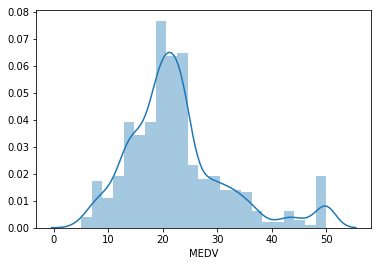

In [22]:
%matplotlib inline
import pandas as pd
import seaborn as sns
#sns.distplot(df.toPandas()['MEDV'])

sns.distplot(df.toPandas()['MEDV'])
plt.show()



### There's some outlier data there past 48 so let's just eliminate it for now

['TOWN', 'TRACT', 'LON', 'LAT', 'MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO']


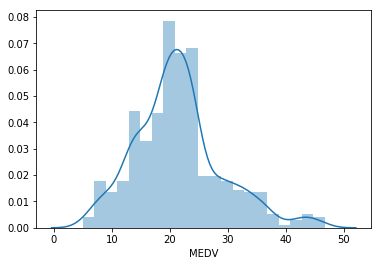

In [23]:
sns.distplot(df.where('MEDV < 48').toPandas()['MEDV'])
print(df.columns)

# If we want to filter out the outliers
dfRaw = dfRaw.where('MEDV < 48')

### Let's put it all together now. Identify the categorical and numeric features and target.


In [24]:
# if filename == 'avocado.csv':
#     df = dfRaw.withColumnRenamed('4046','PLU4046').withColumnRenamed('4225','PLU4225').withColumnRenamed('4770','PLU4770')
#     df.createOrReplaceTempView('dfRaw')
#     df.printSchema()

#     sql = '''select AveragePrice as target, `Total Volume` as totalvolume
#     , PLU4046, PLU4225, PLU4770
#     , `Small Bags` as smallbags, `Large Bags` as largebags, `XLarge Bags` as xlargebags
#     , type, year, region
#     FROM dfRaw'''

#     df = spark.sql(sql)
#     print(df)

#     numeric_features = ['totalvolume','PLU4046', 'PLU4225', 'PLU4770', 'smallbags', 'largebags', 'xlargebags']
#     categorical_features = ['type', 'year','region']
#     target_label = 'target'
#     print(df.take(1))
# else:
numeric_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO']
categorical_features = ['TOWN'] #['TOWN', 'TRACT']
target_label = 'MEDV'
df = dfRaw.select(categorical_features + numeric_features + [target_label])
df.printSchema()

print ('******')
display(df.describe())

print ('******')
display(df)

root
 |-- TOWN: string (nullable = true)
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- MEDV: double (nullable = true)

******


,summary,TOWN,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,count,487,487,487,487,487,487,487,487,487,487,487,487,487
1,mean,None,3.663863696098563,10.944558521560575,11.155215605749499,0.059548254620123205,0.5544979466119098,6.233640657084198,68.29897330595482,3.835432854209443,9.537987679671458,408.8829568788501,18.541478439425056,21.466119096509257
2,stddev,None,8.745039991517844,22.587028902677194,6.820162970724796,0.23689130625554344,0.11678383814441988,0.6371816999531006,28.186892784939175,2.1144699664164612,8.711782762741368,168.18491396396433,2.094241632544032,7.580062510612899
3,min,Arlington,0.00632,0.0,0.74,0,0.385,3.561,2.9,1.137,1,187,12.6,5.0
4,max,Woburn,88.9762,100.0,27.74,1,0.871,8.78,100.0,12.1265,24,711,22.0,46.7


******


,TOWN,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,21.6
2,Swampscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,36.2
5,Marblehead,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,28.7
6,Salem,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,22.9
7,Salem,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,22.1
8,Salem,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,16.5
9,Salem,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,18.9


### Turn the dataframe into vectors.
Use our MakeMLDataFrame helper function to automatically encode the list of categorical values, and bundle everything up into a features and target vector as needed for ML training


In [25]:
dfML = pyh.MakeMLDataFrame(df, categorical_features, numeric_features, target_label, False)
display(dfML)
dfML.printSchema()



,target,features
0,24.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,21.6,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,34.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,33.4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,36.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,28.7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,22.9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,22.1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,16.5,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,18.9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


root
 |-- target: double (nullable = true)
 |-- features: vector (nullable = true)



### Split the dataset into train and test.

In [26]:
train, test = dfML.randomSplit([.7,.3], seed = 1000)
print (f'Training set row count {train.count()}')
print (f'Testing set row count {test.count()}')



Training set row count 353
Testing set row count 134


### Run Linear Regression.

In [27]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='target', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

print("Root Mean Squared Error: {}\nR Squared (R2) {}".format(lrModel.summary.rootMeanSquaredError, lrModel.summary.r2))


Coefficients: [0.0,-3.9585860456555326,-1.0309055163051744,-2.8994064277196827,3.5341175251233103,0.0,-5.019703551634431,0.0,0.0,1.02334691998192,0.0,0.0,0.0,0.0,4.581463791553483,-0.23846760900954825,0.0,2.488029138759902,0.0,0.0,4.153915577732314,-0.12188767790291426,6.881968303891524,0.4688579535107134,0.0,-0.5367317382671063,1.0785496608448664,0.0,-1.0118206081360217,0.14140333128658125,0.0,-5.453505753418422,0.0,1.214333786943776,0.0,0.0,0.0,3.5791808347603915,0.0,0.0,0.0,0.0,0.0,0.0,2.256766123464533,0.0,0.0,1.5702515451589638,0.0,18.777048415832592,0.0,0.0,0.0,1.1436422392034682,0.0,2.9126530329566624,0.0,0.0,0.0,0.0,0.0,0.25833113869573776,0.0,0.0,0.0,0.0,0.0,-1.5232672410373227,0.5693760016469745,0.0,1.220079716004576,0.0,0.0,0.0,0.0,0.0,-0.4381407313031042,0.0,6.712607175752673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0146009375136815,-0.044232293965659746,0.0,0.0,0.0,-1.4110619955100792,5.931197403734559,-0.05047907614077489,-0.0018262735158904675,0.0,-0.003793159793946336,-0.45149401

### Run test data.


In [28]:
lrPredictions = lrModel.transform(test)
display(lrPredictions.select("prediction","target","features"), 30)
from pyspark.ml.evaluation import RegressionEvaluator
lrEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target",metricName="r2")
testResult = lrModel.evaluate(test)
print("Root Mean Squared Error on Test set: {}".format(testResult.rootMeanSquaredError))

,prediction,target,features
0,10.589233,5.6,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,13.388592,7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,11.848338,7.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,10.383451,7.4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,18.537198,7.5,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,12.998608,8.2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,12.388814,8.4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,19.409911,8.4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,7.892482,8.5,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
9,6.660384,8.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


Root Mean Squared Error on Test set: 4.575634281510627


### Try Decision Tree Regression.

In [29]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'target')
dtModel = dt.fit(train)
dtPredictions = dtModel.transform(test)
display(dtPredictions.select("prediction","target","features"), 30)
important = dtModel.featureImportances
print(type(important), important)
#importantDict = zip(important[1], important[2])
#print (importantDict)
print (important[3])
from pyspark.ml.evaluation import RegressionEvaluator
dtEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target",metricName="rmse")
testResult = dtEvaluator.evaluate(dtPredictions)
print("Root Mean Squared Error: {}".format(testResult))
dfML.take(1)

,prediction,target,features
0,9.595455,5.6,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,8.100000,7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9.595455,7.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,9.595455,7.4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,9.595455,7.5,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,11.220000,8.2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,11.220000,8.4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,10.400000,8.4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,9.595455,8.5,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
9,9.595455,8.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


<class 'pyspark.ml.linalg.SparseVector'> (98,[1,3,21,22,41,87,89,91,92,93,94,96,97],[0.0045522984690360415,0.00824513363338062,0.004105367798608914,0.006900883086757505,0.0001637662522639965,0.18395442201440546,0.004693547111917122,0.06084067103565858,0.6047833080264942,0.022246333540723588,0.005273659348113728,0.010195437754589622,0.08404517192805051])
0.00824513363338062
Root Mean Squared Error: 4.347765154433349


[Row(target=24.0, features=SparseVector(98, {74: 1.0, 87: 0.0063, 88: 18.0, 89: 2.31, 91: 0.538, 92: 6.575, 93: 65.2, 94: 4.09, 95: 1.0, 96: 296.0, 97: 15.3}))]

### Try Gradient Boosted Tree.

In [30]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'target', maxIter=10)
gbtModel = gbt.fit(train)
gbtPredictions = gbtModel.transform(test)
display(gbtPredictions.select('prediction', 'target', 'features'), 20)
from pyspark.ml.evaluation import RegressionEvaluator
gbtEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target",metricName="rmse")
testResult = gbtEvaluator.evaluate(gbtPredictions)
print("Root Mean Squared Error: {}".format(testResult))


,prediction,target,features
0,8.405064,5.6,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,7.799321,7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10.189987,7.2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,10.308535,7.4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,9.631079,7.5,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,10.737698,8.2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,11.148564,8.4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,10.435625,8.4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,8.175821,8.5,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
9,10.189987,8.8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


Root Mean Squared Error: 3.9829201555624127
